In [1]:
import cv2                  # resizing image
import numpy as np
import os
from random import shuffle
from tqdm import tqdm       # progress bar for CLI

In [2]:
BASE_DIR = 'X:/Machine_Learning/Data/dogs_vs_cats'
TRAIN_DIR = BASE_DIR + '/train'
TEST_DIR = BASE_DIR + '/test1'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}'.format(LR, '6conv-basic')

In [3]:
# Training image name: 'dog.93.png'
# Test image name: '93.png'

def label_img(img):
    # dog.93.png
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

def prepare_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('./data/train_data.npy', training_data)
    return training_data

def prepare_test_data():
    # 93.png
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('./data/test_data.npy', testing_data)
    return testing_data

In [4]:
training_data = []

if os.path.isfile('./data/train_data.npy'):
    print('Loading training data...')
    training_data = np.load('./data/train_data.npy')
else:
    print('Generating training data...')
    training_data = prepare_train_data()

Loading training data...


In [5]:
# Tensorflow
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

# House this in cnn_model.py
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

c:\users\chano\envs\dogs\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model loaded!')

INFO:tensorflow:Restoring parameters from X:\DEV\PROJECTS\dog-vs-cat\dogsvscats-0.001-6conv-basic
Model loaded!


In [7]:
train = training_data[: -500]
test = training_data[-500:]

In [8]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [9]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 6203  | total loss: 0.27191 | time: 53.849s
| Adam | epoch: 005 | loss: 0.27191 - acc: 0.8825 -- iter: 24448/24500
Training Step: 6204  | total loss: 0.27138 | time: 54.978s
| Adam | epoch: 005 | loss: 0.27138 - acc: 0.8834 | val_loss: 0.51818 - val_acc: 0.7740 -- iter: 24500/24500
--


In [10]:
model.save('model.tfl')

INFO:tensorflow:X:\DEV\PROJECTS\dog-vs-cat\dogsvscats-0.001-6conv-basic is not in all_model_checkpoint_paths. Manually adding it.


In [12]:
test_data = []

if os.path.isfile('./data/test_data.npy'):
    print('Loading test data...')
    test_data = np.load('./data/test_data.npy')
else:
    print('Generating test data...')
    test_data = prepare_test_data()

Loading test data...


In [13]:
print(test_data[3])

[array([[157, 189, 182, ..., 129,  96, 158],
       [198, 210, 175, ..., 114, 171, 159],
       [142, 158, 187, ..., 163, 164, 130],
       ...,
       [132, 155, 107, ..., 173, 120, 165],
       [106, 113, 166, ..., 157, 171, 190],
       [153, 142, 137, ..., 171, 127, 192]], dtype=uint8)
 '1000']


[[0.59631497 0.40368506]]
[[3.5228024e-04 9.9964774e-01]]
[[0.0256589 0.9743411]]
[[0.0840598  0.91594017]]
[[0.787609   0.21239105]]
[[0.45918334 0.54081666]]
[[0.998071   0.00192906]]
[[0.9529682 0.0470318]]
[[0.00195114 0.9980489 ]]
[[0.21351717 0.78648275]]
[[0.99606663 0.0039334 ]]
[[0.8781713  0.12182868]]


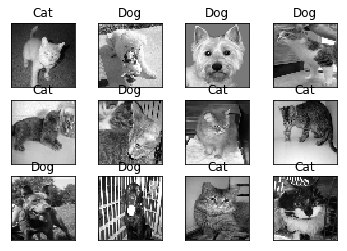

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()

for num, data in enumerate(test_data[72:84]):
    img_data = data[0]
    img_num = data[1]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])
    print(model_out)
    
    str_label = ''
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)    
        
plt.show()

In [18]:
def predict_img(model):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str__label = 'Dog'
    else: str_label = 'Cat'